In [26]:
import casadi as ca
import numpy as np
import pandas as pd
from pytope import Polytope
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


In [27]:
low_bound_control  = (-4, -4)
up_bound_control   = (5,   4)
U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
N_Sam = 20

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 4
size of nu = 2


In [28]:
a = np.array([[1,2],[3,4]])
b = np.array([[5],[6]])
print(np.hstack((a,b)))

[[1 2 5]
 [3 4 6]]


In [29]:
random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)
print(random_vals.shape)

[[ 0.49384283  0.48343855 -0.801531    0.5899421   0.54004285  0.03897391
  -0.13379216  0.60487001 -0.66105577 -0.34958993 -0.03977058 -0.79076604
  -0.98607917  0.35179827 -0.64167207  0.67883856 -0.74109942 -0.59522416
   0.53548821  0.6242469 ]
 [-0.31173379  0.16759451  0.9368855  -0.38143171 -0.23692032  0.46314734
   0.69078009  0.77786002  0.02373776 -0.74401623 -0.96423367  0.27012487
   0.99751077 -0.73208617  0.1284707  -0.67309161 -0.26785621 -0.43375848
  -0.57899693  0.47712164]]
(2, 20)


In [30]:
data_id = "08"
background_filepath = f"../data/{data_id}_background.png"
recordingMeta_filepath = f"../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../data/{data_id}_tracksMeta.csv"

In [31]:
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 11]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
N_Sam = random_vals.shape[1]
print(random_vals.shape)

xPos = filtered_data["xCenter"].to_numpy()
yPos = filtered_data["yCenter"].to_numpy()
position_vals = np.vstack((xPos,yPos))
print(position_vals.shape)

xVel = filtered_data["xVelocity"].to_numpy()
yVel = filtered_data["yVelocity"].to_numpy()
velocity_vals = np.vstack((xVel,yVel))
print(position_vals.shape)

(2, 161)
(2, 161)
(2, 161)


In [32]:
def opti_LP(H):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, N_Sam)

    opti.minimize(rho + np.ones((1, nv))@theta)

    for i in range(N_Sam):
        opti.subject_to(H @ samples[:, i]-H @ y <= theta)

    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [theta, y, rho]) 

In [33]:
f = opti_LP(H)
theta_hat, y_hat, rho_hat = f(random_vals)
print(theta_hat,y_hat,rho_hat)
U_hat_polytope = Polytope(H, theta_hat)+y_hat
print(U_hat_polytope.H)

[1, 1.81593, 2.65829, 1.11096] [0.232337, -8.26785e-15] 1
[[-1.         -0.          0.76766335]
 [-0.         -1.          1.81593002]
 [ 1.          0.          2.89062689]
 [ 0.          1.          1.11095954]]


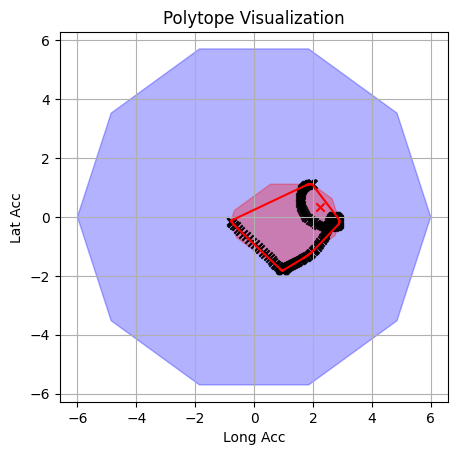

In [51]:
plt.figure()
#original polytope
U_SV_Poly.plot(color = 'b', alpha = 0.3)

#U_hat polytope
U_hat_polytope.plot(color = 'r', alpha = 0.3)

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
y_s_coodinate = np.array(y_hat)
plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

In [35]:
# Radius of the octagon
radius = 6

# Number of vertices
num_vertices = 10

# Generate the vertex coordinates
angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)  # Divide circle into 8 parts
x_coords = radius * np.cos(angles)
y_coords = radius * np.sin(angles)

# Combine x and y coordinates
vertices = np.column_stack((x_coords, y_coords))

In [36]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


In [37]:
f = opti_LP(H)
theta_hat, y_hat, rho_hat = f(random_vals)
print(theta_hat,y_hat,rho_hat)
U_hat_polytope = Polytope(H, theta_hat)+y_hat

[0.306024, 0.307974, 0.242674, 0.220441, 0.306294, 0.271908, 0.293092, 0.248672, 0.307974, 0.192289] [1.06036, -0.146519] 0.307974


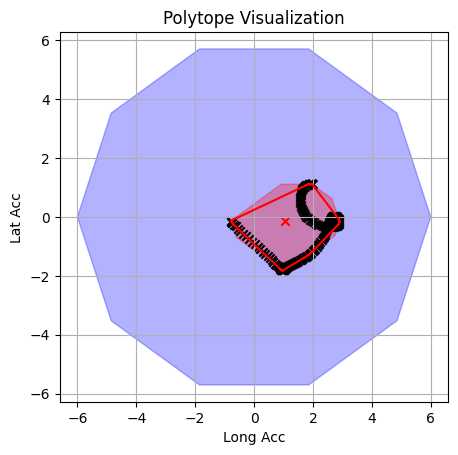

In [38]:
plt.figure()
#original polytope
U_SV_Poly.plot(color = 'b', alpha = 0.3)

#U_hat polytope
U_hat_polytope.plot(color = 'r', alpha = 0.3)

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
y_s_coodinate = np.array(y_hat)
plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

## Moving Horizon Method ##

In [39]:
mh_window_size = 50

In [40]:
def opti_LP_mh(H,mh_window_size):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, mh_window_size)

    opti.minimize(rho + np.ones((1, nv))@theta)

    for i in range(mh_window_size):
        opti.subject_to(H @ samples[:, i]-H @ y <= theta)

    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [theta, y, rho]) 

In [41]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

f_mh = opti_LP_mh(H,mh_window_size)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


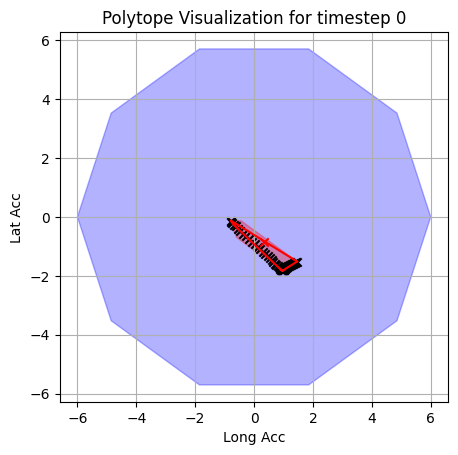

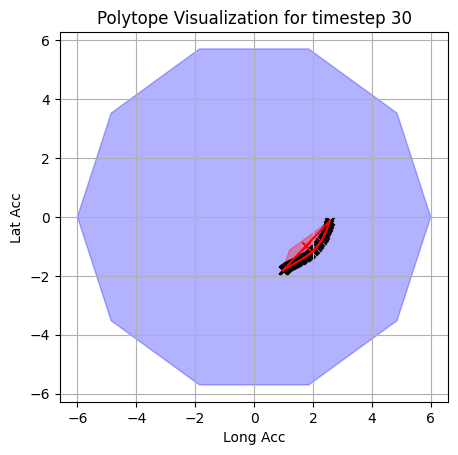

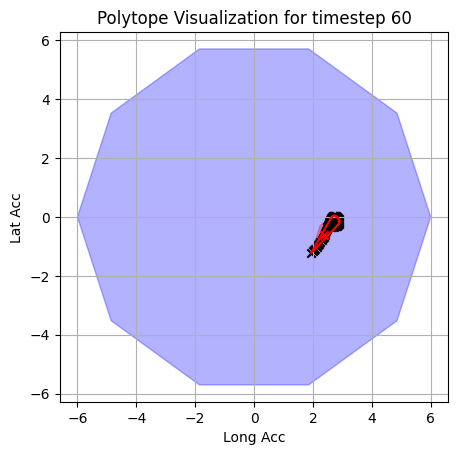

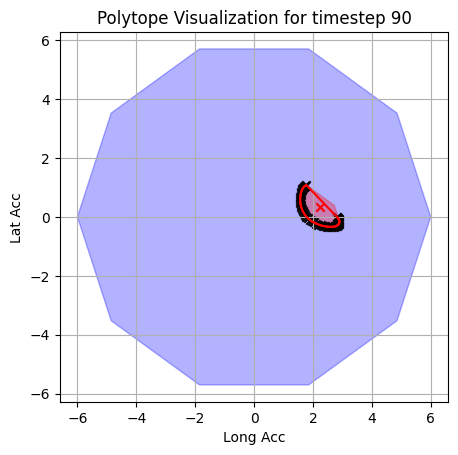

In [42]:
for i in range(N_Sam-mh_window_size):
    if(i%30 == 0):
        theta_hat, y_hat, rho_hat = f_mh(random_vals[:,i:i+mh_window_size])
        U_hat_polytope = Polytope(H, theta_hat)+y_hat
        
        #original polytope
        U_SV_Poly.plot(color = 'b', alpha = 0.3)

        #U_hat polytope
        U_hat_polytope.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(random_vals[0,i:i+mh_window_size],random_vals[1,i:i+mh_window_size],marker='x',color = 'black')

        #y
        y_s_coodinate = np.array(y_hat)
        plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        points = random_vals[:,i:i+mh_window_size].T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Polytope Visualization for timestep {i}")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()

## Online Recursive Method ##

In [43]:
def opti_LP_OR(H):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, 1)
    y_pre = opti.parameter(nu,1)
    theta_pre = opti.parameter(nv,1)

    opti.minimize(rho + np.ones((1, nv))@theta)

    opti.subject_to(H @ samples-H @ y <= theta)
    opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho]) 

In [44]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

nv = np.size(H, 0)
nu = np.size(H, 1)

f_or = opti_LP_OR(H)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


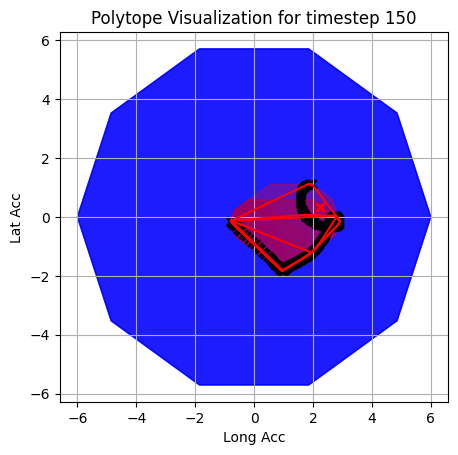

In [45]:
#initialization
theta_pre, y_pre, rho_pre = f_or(np.array([[0],[0]]),np.zeros((nu,1)),0.1*np.ones((nv,1)))

for i in range(N_Sam):
    theta_pre,y_pre,rho_pre = f_or(random_vals[:,i],y_pre,theta_pre)
    U_hat_polytope = Polytope(H, theta_pre)+y_pre

    if(i%30 == 0):
        #original polytope
        U_SV_Poly.plot(color = 'b', alpha = 0.3)

        #U_hat polytope
        U_hat_polytope.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(random_vals[0,:i+1],random_vals[1,:i+1],marker='x',color = 'black')

        #y
        y_s_coodinate = np.array(y_hat)
        plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        if i > 1:
            points = random_vals[:,:i+1].T
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Polytope Visualization for timestep {i}")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        #plt.show()
    

In [46]:
N = 5
T = 1/25
A_SV = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
B_SV = np.array([[0.5*T**2, 0], [T, 0], [0, 0.5*T**2], [0, T]])
BU = B_SV*U_hat_polytope
Reachable_Set = list()
Occupancy_SV = list()
x_t = np.array([position_vals[0, 100], velocity_vals[0, 100], position_vals[1, 100], velocity_vals[1, 100]])
print(x_t.shape)
Reachable_Set.append(x_t)

(4,)


In [47]:
print((A_SV@x_t).shape)
print(BU)

(4,)
Polytope in R^4


In [48]:
for t in range(1,N+1):
    if t == 1:
        reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
    else:
        reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
    
    vertex = reachable_set_t.V
    vertex_xy = np.delete(vertex, [1, 3], axis = 1)
    occupancy_SV_t = Polytope(vertex_xy) 
    occupancy_SV_t.minimize_V_rep( )
    temp_poly   = occupancy_SV_t

    Occupancy_SV.append(temp_poly)
    Reachable_Set.append(reachable_set_t)

In [49]:
print(Occupancy_SV[0].V)

[[ 61.5710515  -32.85433961]
 [ 61.57119908 -32.8547938 ]
 [ 61.57243534 -32.855692  ]
 [ 61.57256825 -32.855692  ]
 [ 61.57387776 -32.85474058]
 [ 61.57399933 -32.85436642]
 [ 61.57379704 -32.85374384]
 [ 61.57325179 -32.85334769]
 [ 61.57212391 -32.85334769]
 [ 61.571142   -32.85406109]]


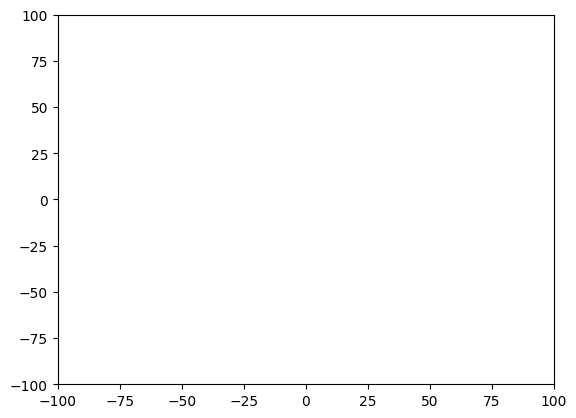

In [50]:
for i in range(len(Occupancy_SV)):
    Occupancy_SV[i].plot()
    plt.xlim(-100,100)
    plt.ylim(-100,100)